In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics_portfolio import PortfolioManager

from careamics.config.support import SupportedTransform
from careamics.config.configuration_factories import create_n2v_configuration
from careamics.lightning.dataset_ng.lightning_module import UNetModule
from careamics.lightning.dataset_ng.data_module import CareamicsDataModule

In [2]:
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n20.download()
files.sort()

# load images
train_data = np.load(files[1])["X_train"]
print(f"Train data shape: {train_data.shape}")

Train data shape: (908, 128, 128)


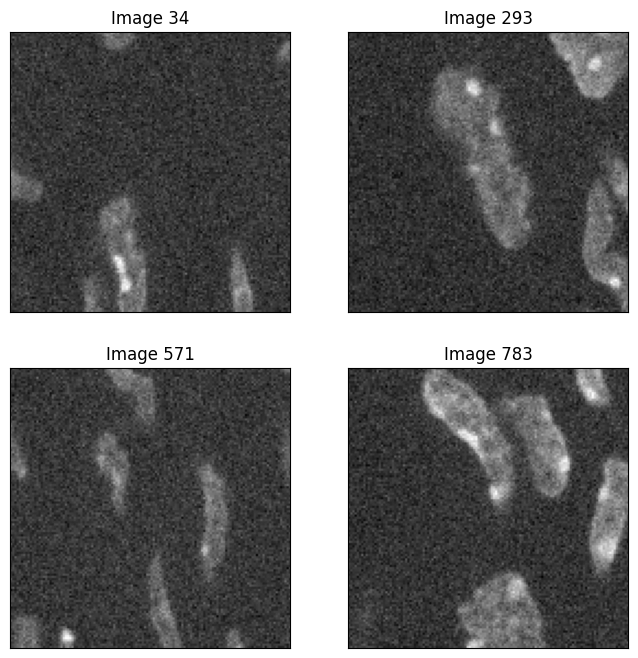

In [3]:
indices = [34, 293, 571, 783]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(train_data[indices[0]], cmap="gray")
ax[0, 0].set_title(f"Image {indices[0]}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(train_data[indices[1]], cmap="gray")
ax[0, 1].set_title(f"Image {indices[1]}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(train_data[indices[2]], cmap="gray")
ax[1, 0].set_title(f"Image {indices[2]}")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(train_data[indices[3]], cmap="gray")
ax[1, 1].set_title(f"Image {indices[3]}")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

In [4]:
config = create_n2v_configuration(
    experiment_name="mouse_nuclei_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                                     'strategy': 'uniform',
                

In [5]:
mean = np.mean([data.mean() for data in train_data])
std = np.mean([data.std() for data in train_data])
config.data_config.set_means_and_stds([mean], [std])

# Ensuring that transforms are set 
config.data_config.transforms =[
    { 
        "name": SupportedTransform.XY_FLIP.value,
        "flip_x": True, 
        "flip_y": True,
    },
    {
        "name": SupportedTransform.XY_RANDOM_ROTATE90.value,
    },   
]

In [6]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


In [7]:
train_data_module = CareamicsDataModule(
    data_config=config.data_config,
    train_data=train_data,
    val_data=val_data,
)

model = UNetModule(config.algorithm_config)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

root = Path("nuclei_n2v")
callbacks = [   
    ModelCheckpoint(
        dirpath=root / "checkpoints",
        filename="nuclei_new_lightning_module",
        save_last=True,
        monitor="val_loss",
        mode="min",
    ),
]
logger = WandbLogger(
    project="nuclei-n2v", name="nuclei_new_lightning_module"
)

trainer = Trainer(
    max_epochs=10, 
    default_root_dir=root,
    callbacks=callbacks,
    logger=logger
)
trainer.fit(model, datamodule=train_data_module)

In [9]:
from careamics.config.inference_model import InferenceConfig
from careamics.dataset_ng.legacy_interoperability import imageregions_to_tileinfos
from careamics.prediction_utils import convert_outputs

train_data = np.load(files[1])["X_train"]

config = InferenceConfig(
    model_config=config,
    data_type="array",
    tile_size=(64, 64),
    tile_overlap=(32, 32),
    axes="SYX",
    batch_size=1,
    image_means=train_data_module.train_dataset.input_stats.means,
    image_stds=train_data_module.train_dataset.input_stats.stds
)

inf_data_module = CareamicsDataModule(
    data_config=config,
    pred_data=train_data
)

In [ ]:
predictions = trainer.predict(model, datamodule=inf_data_module)
tile_infos = imageregions_to_tileinfos(predictions)
predictions = convert_outputs(tile_infos, tiled=True)
predictions = np.stack(predictions).squeeze()

In [13]:
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

gt_data = np.load(files[1])["X_train"]
print(f"GT data shape: {gt_data.shape}")
print(f"Predictions shape: {predictions.shape}")

GT data shape: (908, 128, 128)
Predictions shape: (908, 128, 128)


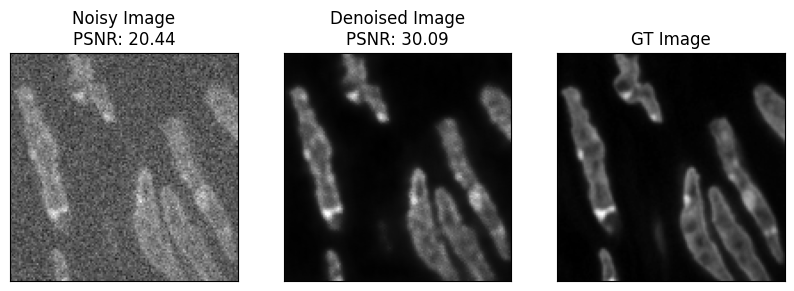

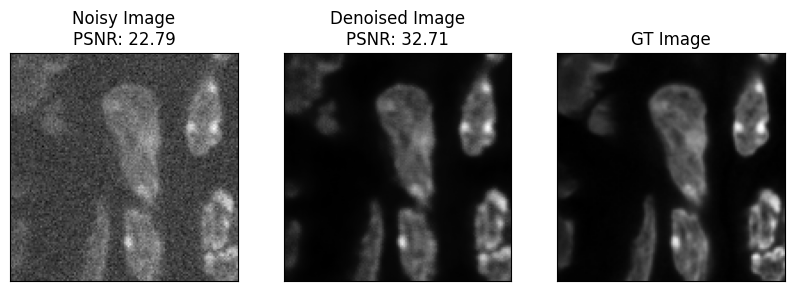

In [15]:
from careamics.utils.metrics import psnr, scale_invariant_psnr

indices = [389, 621]

for i in indices:
    # compute psnr
    psnr_noisy = scale_invariant_psnr(gt_data[i], train_data[i])
    psnr_denoised = scale_invariant_psnr(gt_data[i], predictions[i].squeeze())

    # plot images
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(train_data[i], cmap="gray")
    ax[0].set_title(f"Noisy Image\nPSNR: {psnr_noisy:.2f}")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(predictions[i].squeeze(), cmap="gray")
    ax[1].set_title(f"Denoised Image\nPSNR: {psnr_denoised:.2f}")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].imshow(gt_data[i], cmap="gray")
    ax[2].set_title("GT Image")
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    plt.show()

In [16]:
psnrs = np.zeros(gt_data.shape[0])

for i in range(gt_data.shape[0]):
    psnrs[i] = scale_invariant_psnr(gt_data[i], predictions[i].squeeze())

print(f"PSNR: {np.mean(psnrs):.2f} ± {np.std(psnrs):.2f}")

PSNR: 32.56 ± 2.11
